-----
# 타이타닉 생존자 예측하기
- https://www.kaggle.com/c/titanic/data
- https://cyc1am3n.github.io/2018/10/09/my-first-kaggle-competition_titanic.html
- 목표: 결과적으로 어떤 승객이 살아 남았는지 죽었는지 판단
-----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn

from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import matplotlib
matplotlib.rcParams["axes.unicode_minus"] = False
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans

### 1. 데이터 준비하기

In [9]:
train = pd.read_csv("data/titanic/train.csv")
test = pd.read_csv("data/titanic/test.csv")
print(train.head())
print(test.head()) # 정답이 없다
train.shape #특성
test.shape
train.info

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25  

In [11]:
# 결측치의 전체 합계
train.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 2. 탐색적 데이터 분석
    - Survivied는 생존 여부(0은 사망, 1은 생존; train 데이터에서만 제공),
    - Pclass는 사회경제적 지위(1에 가까울 수록 높음),
    - SipSp는 배우자나 형제 자매 명 수의 총 합,
    - Parch는 부모 자식 명 수의 총 합을 나타낸다.

In [25]:
def bar_chart(feature):
    survived = train[train["Survived"]==1][feature].value_counts()
    dead = train[train["Survived"]==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ["Survived","Dead"]
    df.plot(kind="bar", stacked=True, figsize=(10,5))

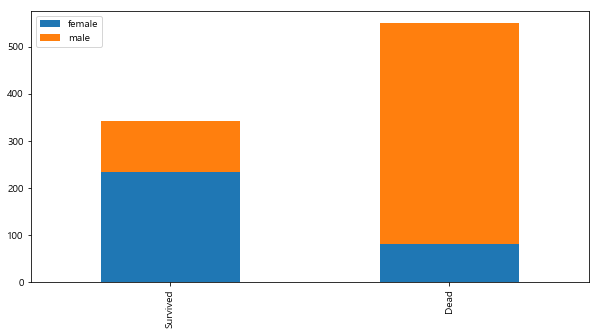

In [26]:
bar_chart("Sex")

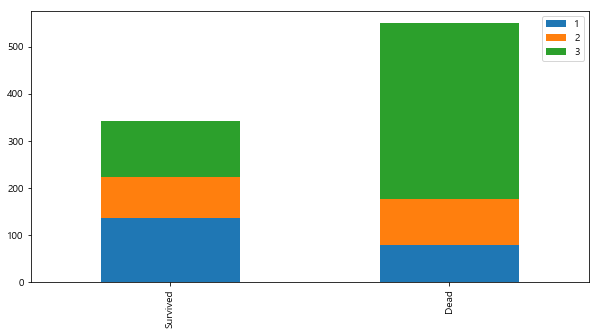

In [27]:
bar_chart("Pclass")

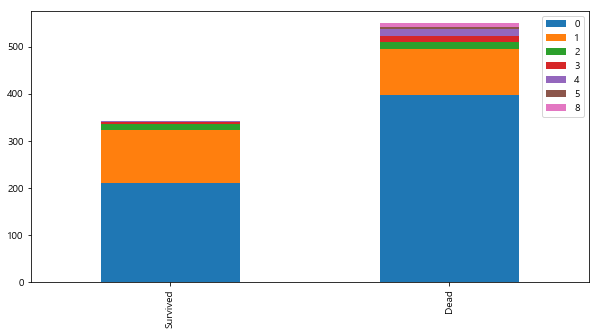

In [30]:
bar_chart("SibSp")

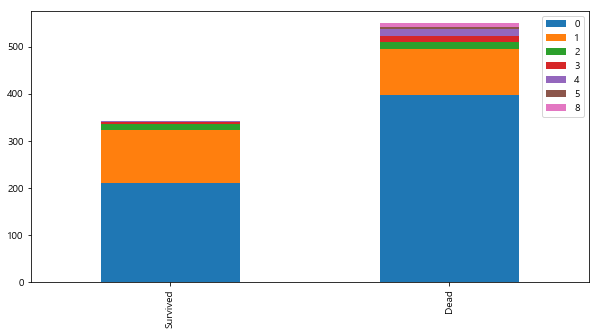

In [31]:
bar_chart()

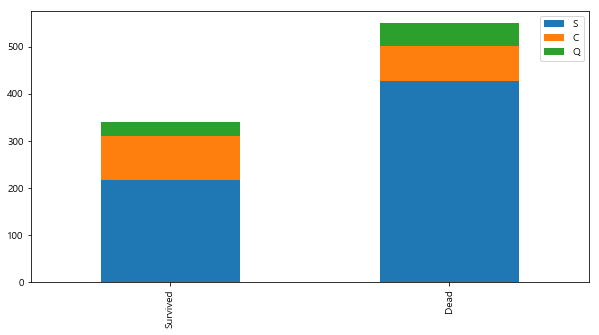

In [32]:
bar_chart("Embarked")

In [ ]:
## feature engineering

### 3. 데이터 전처리 및 특성 추출
#### 3-1. name feature
- 무조건 버리기 보다는 mr, mrs, miss 부분이 정보를 갖고 있을수 있음
- 이부분을 추출한다

In [37]:
train.head()

train_test_data = [train, test] # 데이터 합치기
for dataset in train_test_data: # 정규표현식
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    #  ’ ([A-Za-z]+).‘는 정규표현식인데, 공백으로 시작하고, .으로 끝나는 문자열을 추출시

In [40]:
train.head()
test.head()
print(train["Title"].value_counts())
print(test["Title"].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Jonkheer      1
Mme           1
Countess      1
Sir           1
Capt          1
Ms            1
Don           1
Lady          1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64


In [43]:
# Mr, Miss, Mrs 이외의 other로 처리
title_mapping = {"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Dr":3, "Rev":3, "Col":3, "Major":3, \
                 "Mile":3, "Countless":3, "Ms":3, "Lady":3, "Johnheer":3, "Don":3, "Dona":3, \
                "Mme":3, "Capt":3, "Sir":3 }

for dataset in train_test_data:
    dataset["Title"] = dataset["Title"].map(title_mapping)

In [45]:
print(train["Title"].value_counts())
print(test["Title"].value_counts())

0.0    517
1.0    182
2.0    125
3.0     63
Name: Title, dtype: int64
0    240
1     78
2     72
3     28
Name: Title, dtype: int64


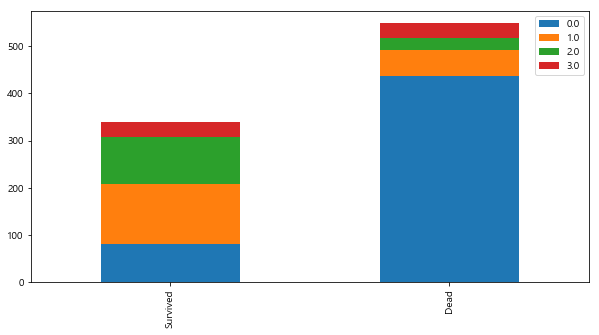

In [46]:
bar_chart("Title")

In [47]:
train.drop("Name", axis=1, inplace=True)
test.drop("Name", axis=1, inplace=True)

In [48]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2


#### 3-2. sex 
    - 문자->숫자

In [51]:
sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset["Sex"] = dataset["Sex"].map(sex_mapping)

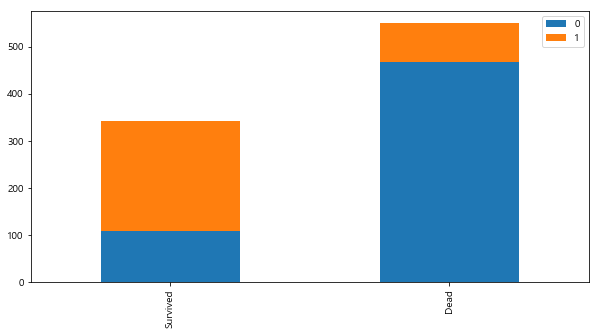

In [52]:
train.head()
test.head()
bar_chart("Sex")

#### 3-3. Age

In [53]:
train.isnull().sum()
# 남자는 남자들의 평균나이로 처리
# miss는 miss들의 평균나이로 처리

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            4
dtype: int64

In [57]:
# nan값을 채우겠다
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [58]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            4
dtype: int64

(20, 30)

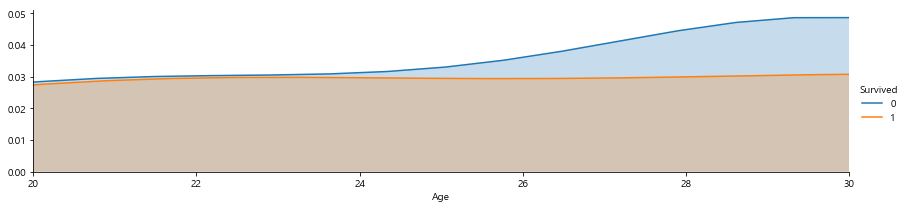

In [65]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, "Age", shade=True)
# facet.set(xlim=(0, train["Age"].max()))
facet.add_legend()
plt.xlim(20, 30)

In [ ]:
# binning

